## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-07-10 14:15:50.926898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 14:15:50.927020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 14:15:51.093978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Extract Image Features

In [3]:
# load Xception model
model = Xception()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

None


In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for Xception
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1720620972.215809     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

## Preprocess Text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

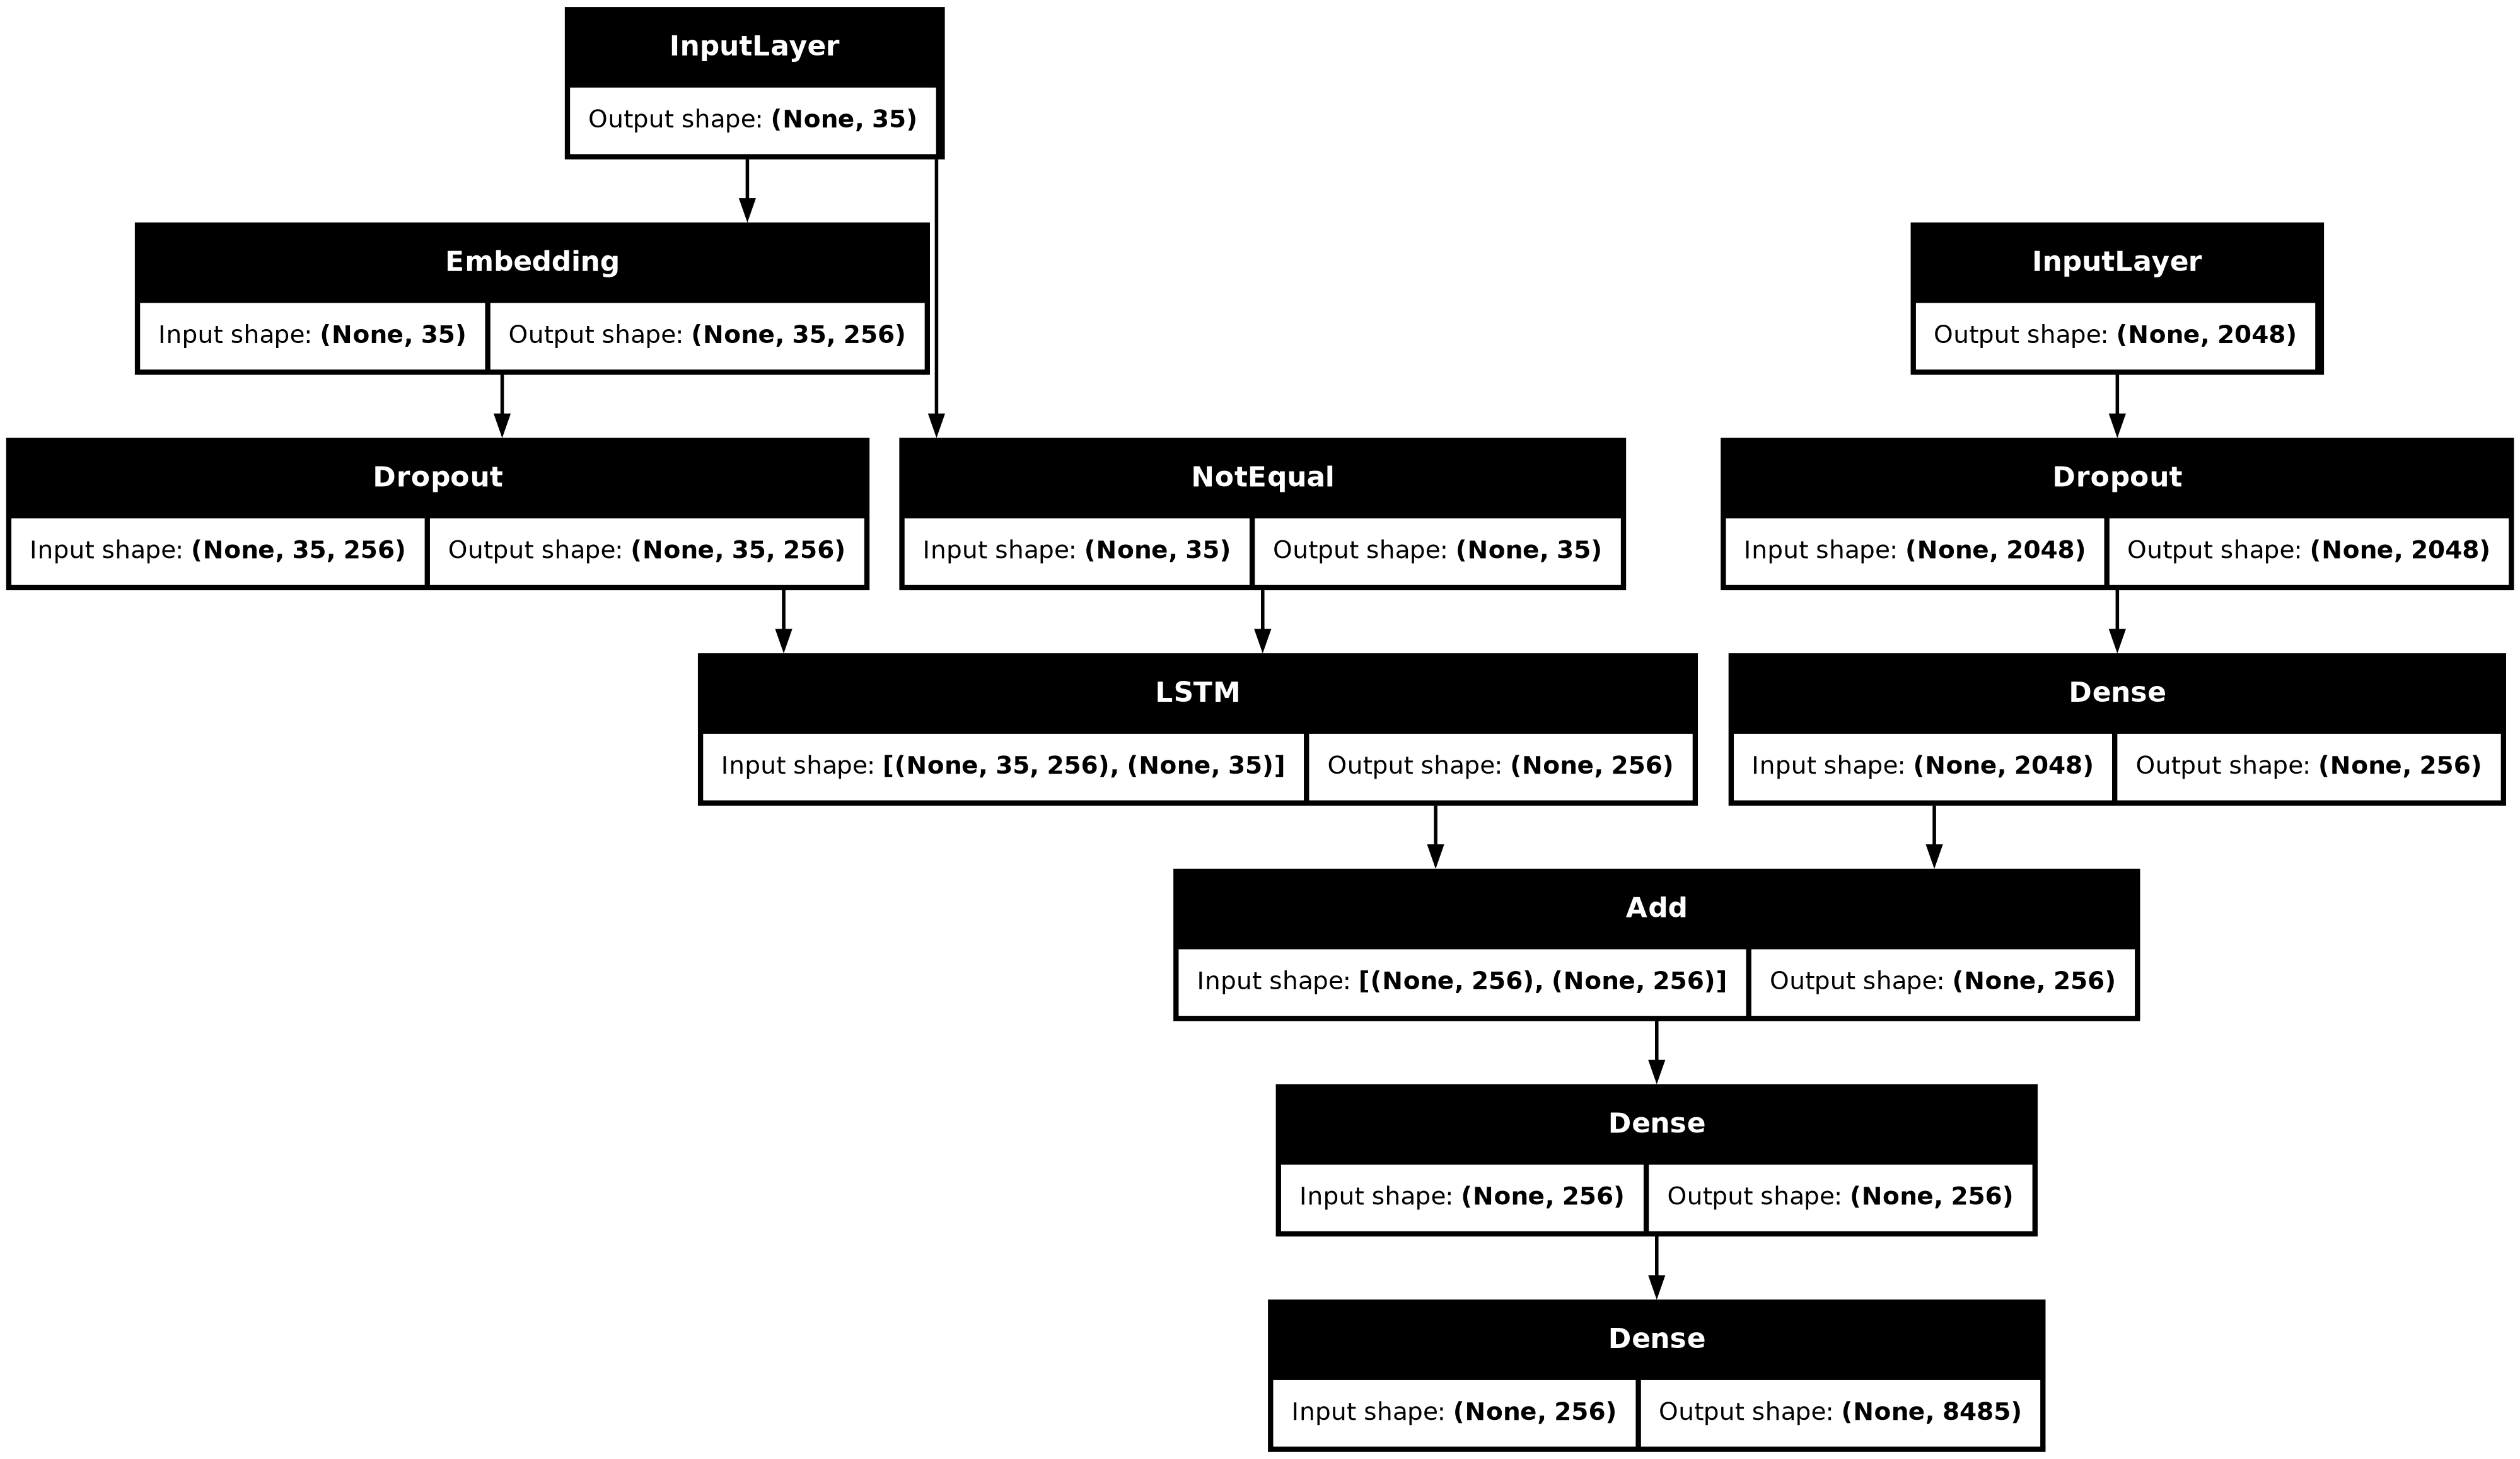

In [23]:
# encoder model
# image feature layers
# inputs1 = Input(shape=(4096,), name="image")
# inputs1 = Input(shape=(1920,), name="image")
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [24]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  1/227 ━━━━━━━━━━━━━━━━━━━━ 26:47 7s/step - loss: 9.0518

W0000 00:00:1720621619.012080     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621619.067469     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621619.133128     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/227 ━━━━━━━━━━━━━━━━━━━━ 16:48 4s/step - loss: 9.0369

W0000 00:00:1720621623.496645     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621623.551180     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621623.614167     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/227 ━━━━━━━━━━━━━━━━━━━━ 16:54 5s/step - loss: 9.0185

W0000 00:00:1720621628.083642     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621628.132965     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621628.191424     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/227 ━━━━━━━━━━━━━━━━━━━━ 16:41 4s/step - loss: 8.9915

W0000 00:00:1720621632.493719     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621632.548423     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621632.611351     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/227 ━━━━━━━━━━━━━━━━━━━━ 16:34 4s/step - loss: 8.9580

W0000 00:00:1720621636.935314     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621636.990157     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621637.054506     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/227 ━━━━━━━━━━━━━━━━━━━━ 13:50 4s/step - loss: 8.8560

W0000 00:00:1720621641.674643     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621641.730486     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621641.794919     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/227 ━━━━━━━━━━━━━━━━━━━━ 14:12 4s/step - loss: 8.7872

W0000 00:00:1720621646.242776     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621646.245935     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621646.299370     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621646.366376     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/227 ━━━━━━━━━━━━━━━━━━━━ 14:25 4s/step - loss: 8.7090

W0000 00:00:1720621650.786361     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621650.841762     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621650.907072     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/227 ━━━━━━━━━━━━━━━━━━━━ 14:38 4s/step - loss: 8.6278

W0000 00:00:1720621655.448794     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621655.504963     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621655.569400     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/227 ━━━━━━━━━━━━━━━━━━━━ 14:44 4s/step - loss: 8.5471

W0000 00:00:1720621659.964287     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621659.967895     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621660.019863     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621660.082949     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/227 ━━━━━━━━━━━━━━━━━━━━ 14:52 4s/step - loss: 8.4717

W0000 00:00:1720621664.662026     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621664.665238     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621664.719087     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621664.784049     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 13/227 ━━━━━━━━━━━━━━━━━━━━ 14:55 4s/step - loss: 8.4014

W0000 00:00:1720621669.230948     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621669.286380     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621669.351823     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/227 ━━━━━━━━━━━━━━━━━━━━ 14:59 4s/step - loss: 8.3369

W0000 00:00:1720621673.923597     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621673.926573     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621673.980021     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621674.044373     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/227 ━━━━━━━━━━━━━━━━━━━━ 15:02 4s/step - loss: 8.2756

W0000 00:00:1720621678.628865     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621678.678016     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621678.737335     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/227 ━━━━━━━━━━━━━━━━━━━━ 15:04 4s/step - loss: 8.2179

W0000 00:00:1720621683.298424     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621683.301524     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621683.353802     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621683.419314     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/227 ━━━━━━━━━━━━━━━━━━━━ 15:05 4s/step - loss: 8.1630

W0000 00:00:1720621687.991375     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621687.994677     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621688.047075     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621688.110199     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/227 ━━━━━━━━━━━━━━━━━━━━ 15:04 4s/step - loss: 8.1101

W0000 00:00:1720621692.585766     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621692.588954     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621692.641397     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621692.709826     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/227 ━━━━━━━━━━━━━━━━━━━━ 15:03 4s/step - loss: 8.0599

W0000 00:00:1720621697.170387     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621697.225570     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621697.296098     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/227 ━━━━━━━━━━━━━━━━━━━━ 15:00 4s/step - loss: 8.0126

W0000 00:00:1720621701.709895     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621701.759082     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621701.818698     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/227 ━━━━━━━━━━━━━━━━━━━━ 14:59 4s/step - loss: 7.9673

W0000 00:00:1720621706.330024     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621706.333191     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621706.385391     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621706.447391     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/227 ━━━━━━━━━━━━━━━━━━━━ 14:56 4s/step - loss: 7.9239

W0000 00:00:1720621710.902443     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621710.950618     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621711.017720     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 23/227 ━━━━━━━━━━━━━━━━━━━━ 14:55 4s/step - loss: 7.8826

W0000 00:00:1720621715.533826     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621715.589080     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621715.656308     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/227 ━━━━━━━━━━━━━━━━━━━━ 14:53 4s/step - loss: 7.8432

W0000 00:00:1720621720.275808     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621720.331510     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621720.397190     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 25/227 ━━━━━━━━━━━━━━━━━━━━ 14:51 4s/step - loss: 7.8055

W0000 00:00:1720621724.881229     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621724.934912     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621724.997858     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/227 ━━━━━━━━━━━━━━━━━━━━ 14:47 4s/step - loss: 7.7697

W0000 00:00:1720621729.462404     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621729.516264     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621729.579408     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/227 ━━━━━━━━━━━━━━━━━━━━ 14:44 4s/step - loss: 7.7356

W0000 00:00:1720621733.963157     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621733.966414     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621734.020080     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621734.084927     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 28/227 ━━━━━━━━━━━━━━━━━━━━ 14:41 4s/step - loss: 7.7030

W0000 00:00:1720621738.645465     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621738.699322     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621738.760749     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/227 ━━━━━━━━━━━━━━━━━━━━ 13:34 4s/step - loss: 7.6124

W0000 00:00:1720621743.701979     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621743.705167     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621743.758584     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621743.823093     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 32/227 ━━━━━━━━━━━━━━━━━━━━ 13:33 4s/step - loss: 7.5844

W0000 00:00:1720621748.410653     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621748.413941     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621748.466324     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621748.529658     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 33/227 ━━━━━━━━━━━━━━━━━━━━ 13:33 4s/step - loss: 7.5574

W0000 00:00:1720621753.233047     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621753.282369     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621753.342133     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/227 ━━━━━━━━━━━━━━━━━━━━ 13:05 4s/step - loss: 7.5061

W0000 00:00:1720621758.065928     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621758.121454     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621758.186434     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/227 ━━━━━━━━━━━━━━━━━━━━ 13:04 4s/step - loss: 7.4817

W0000 00:00:1720621762.772569     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621762.827553     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621762.891755     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/227 ━━━━━━━━━━━━━━━━━━━━ 13:02 4s/step - loss: 7.4580

W0000 00:00:1720621767.227274     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621767.230612     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621767.282584     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621767.344473     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/227 ━━━━━━━━━━━━━━━━━━━━ 13:00 4s/step - loss: 7.4352

W0000 00:00:1720621771.738191     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621771.792562     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621771.861734     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/227 ━━━━━━━━━━━━━━━━━━━━ 12:58 4s/step - loss: 7.4131

W0000 00:00:1720621776.390072     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621776.444296     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621776.510245     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/227 ━━━━━━━━━━━━━━━━━━━━ 12:57 4s/step - loss: 7.3916

W0000 00:00:1720621781.158601     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621781.213415     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621781.277700     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/227 ━━━━━━━━━━━━━━━━━━━━ 12:55 4s/step - loss: 7.3708

W0000 00:00:1720621785.888734     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621785.943806     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621786.008376     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/227 ━━━━━━━━━━━━━━━━━━━━ 12:54 4s/step - loss: 7.3506

W0000 00:00:1720621790.602804     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621790.605844     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621790.658279     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621790.720810     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/227 ━━━━━━━━━━━━━━━━━━━━ 12:52 4s/step - loss: 7.3310

W0000 00:00:1720621795.445551     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621795.495026     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621795.555134     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/227 ━━━━━━━━━━━━━━━━━━━━ 12:30 4s/step - loss: 7.2933

W0000 00:00:1720621800.426034     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621800.475153     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621800.535019     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/227 ━━━━━━━━━━━━━━━━━━━━ 12:29 4s/step - loss: 7.2752

W0000 00:00:1720621805.269863     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621805.318716     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621805.377519     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/227 ━━━━━━━━━━━━━━━━━━━━ 12:27 4s/step - loss: 7.2574

W0000 00:00:1720621810.121506     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621810.170940     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621810.230518     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/227 ━━━━━━━━━━━━━━━━━━━━ 12:26 4s/step - loss: 7.2400

W0000 00:00:1720621815.040194     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621815.094338     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621815.158000     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/227 ━━━━━━━━━━━━━━━━━━━━ 12:23 4s/step - loss: 7.2230

W0000 00:00:1720621819.571211     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621819.619122     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621819.681279     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/227 ━━━━━━━━━━━━━━━━━━━━ 12:03 4s/step - loss: 7.1904

W0000 00:00:1720621824.442930     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621824.446117     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621824.498925     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621824.563581     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/227 ━━━━━━━━━━━━━━━━━━━━ 12:01 4s/step - loss: 7.1747

W0000 00:00:1720621829.368532     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621829.422650     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621829.486254     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/227 ━━━━━━━━━━━━━━━━━━━━ 11:59 4s/step - loss: 7.1592

W0000 00:00:1720621834.128776     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621834.183866     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621834.249557     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/227 ━━━━━━━━━━━━━━━━━━━━ 11:58 4s/step - loss: 7.1442

W0000 00:00:1720621839.147327     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621839.202089     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621839.266419     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/227 ━━━━━━━━━━━━━━━━━━━━ 11:56 4s/step - loss: 7.1294

W0000 00:00:1720621843.942941     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621843.992164     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621844.051942     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/227 ━━━━━━━━━━━━━━━━━━━━ 11:54 4s/step - loss: 7.1152

W0000 00:00:1720621848.929965     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621848.987677     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621849.055685     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/227 ━━━━━━━━━━━━━━━━━━━━ 11:52 4s/step - loss: 7.1015

W0000 00:00:1720621853.688170     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621853.743738     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621853.808310     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/227 ━━━━━━━━━━━━━━━━━━━━ 11:50 4s/step - loss: 7.0880

W0000 00:00:1720621858.616788     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621858.620099     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621858.672522     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621858.736018     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/227 ━━━━━━━━━━━━━━━━━━━━ 11:32 4s/step - loss: 7.0618

W0000 00:00:1720621863.648644     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621863.702320     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621863.774603     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/227 ━━━━━━━━━━━━━━━━━━━━ 11:30 4s/step - loss: 7.0491

W0000 00:00:1720621868.468459     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621868.524264     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621868.590061     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 63/227 ━━━━━━━━━━━━━━━━━━━━ 11:13 4s/step - loss: 7.0244

W0000 00:00:1720621873.480539     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621873.529135     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621873.588092     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/227 ━━━━━━━━━━━━━━━━━━━━ 10:42 4s/step - loss: 6.9891

W0000 00:00:1720621878.536499     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621878.591083     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621878.654825     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/227 ━━━━━━━━━━━━━━━━━━━━ 10:40 4s/step - loss: 6.9777

W0000 00:00:1720621883.130694     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621883.185389     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621883.248300     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/227 ━━━━━━━━━━━━━━━━━━━━ 10:25 4s/step - loss: 6.9556

W0000 00:00:1720621888.008715     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621888.063574     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621888.126699     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 70/227 ━━━━━━━━━━━━━━━━━━━━ 10:23 4s/step - loss: 6.9448

W0000 00:00:1720621892.869568     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621892.918974     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621892.977274     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/227 ━━━━━━━━━━━━━━━━━━━━ 10:08 4s/step - loss: 6.9237

W0000 00:00:1720621897.642333     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621897.695767     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621897.758669     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/227 ━━━━━━━━━━━━━━━━━━━━ 10:05 4s/step - loss: 6.9133

W0000 00:00:1720621902.225246     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621902.274344     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621902.333027     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/227 ━━━━━━━━━━━━━━━━━━━━ 10:03 4s/step - loss: 6.9031

W0000 00:00:1720621906.812880     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621906.869097     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621906.935016     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/227 ━━━━━━━━━━━━━━━━━━━━ 10:00 4s/step - loss: 6.8931

W0000 00:00:1720621911.242938     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621911.246040     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621911.298212     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621911.360964     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 76/227 ━━━━━━━━━━━━━━━━━━━━ 9:57 4s/step - loss: 6.8832 

W0000 00:00:1720621916.004502     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621916.007621     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621916.060003     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621916.122019     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/227 ━━━━━━━━━━━━━━━━━━━━ 9:44 4s/step - loss: 6.8638

W0000 00:00:1720621920.955540     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621921.009014     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621921.071407     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 79/227 ━━━━━━━━━━━━━━━━━━━━ 9:41 4s/step - loss: 6.8543

W0000 00:00:1720621925.636382     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621925.639520     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621925.692760     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621925.756688     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/227 ━━━━━━━━━━━━━━━━━━━━ 9:28 4s/step - loss: 6.8359

W0000 00:00:1720621930.409854     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621930.464896     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621930.527887     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/227 ━━━━━━━━━━━━━━━━━━━━ 9:25 4s/step - loss: 6.8269

W0000 00:00:1720621934.843716     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621934.847070     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621934.900284     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621934.962238     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/227 ━━━━━━━━━━━━━━━━━━━━ 9:23 4s/step - loss: 6.8180

W0000 00:00:1720621939.625036     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621939.680787     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621939.745393     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 84/227 ━━━━━━━━━━━━━━━━━━━━ 9:20 4s/step - loss: 6.8092

W0000 00:00:1720621944.206387     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621944.210385     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621944.262314     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621944.325057     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 86/227 ━━━━━━━━━━━━━━━━━━━━ 9:07 4s/step - loss: 6.7920

W0000 00:00:1720621949.004372     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621949.057628     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621949.120308     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/227 ━━━━━━━━━━━━━━━━━━━━ 9:04 4s/step - loss: 6.7836

W0000 00:00:1720621953.712159     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621953.766457     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621953.828474     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/227 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - loss: 6.7753

W0000 00:00:1720621958.560267     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621958.615779     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621958.681138     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/227 ━━━━━━━━━━━━━━━━━━━━ 9:00 4s/step - loss: 6.7671

W0000 00:00:1720621963.378174     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621963.381585     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621963.434175     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621963.496999     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/227 ━━━━━━━━━━━━━━━━━━━━ 8:57 4s/step - loss: 6.7590

W0000 00:00:1720621968.418568     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621968.421973     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621968.474302     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621968.538019     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/227 ━━━━━━━━━━━━━━━━━━━━ 8:55 4s/step - loss: 6.7510

W0000 00:00:1720621973.389901     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621973.393022     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621973.446229     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621973.507971     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/227 ━━━━━━━━━━━━━━━━━━━━ 8:52 4s/step - loss: 6.7430

W0000 00:00:1720621978.295645     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621978.344300     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621978.412944     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 93/227 ━━━━━━━━━━━━━━━━━━━━ 8:50 4s/step - loss: 6.7352

W0000 00:00:1720621983.063958     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621983.113300     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621983.173255     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 94/227 ━━━━━━━━━━━━━━━━━━━━ 8:47 4s/step - loss: 6.7275

W0000 00:00:1720621987.868839     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621987.872020     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621987.925587     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621987.989561     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 96/227 ━━━━━━━━━━━━━━━━━━━━ 8:35 4s/step - loss: 6.7123

W0000 00:00:1720621992.506544     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621992.555463     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621992.614400     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/227 ━━━━━━━━━━━━━━━━━━━━ 8:23 4s/step - loss: 6.6974

W0000 00:00:1720621997.611741     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621997.666078     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720621997.728830     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/227 ━━━━━━━━━━━━━━━━━━━━ 8:11 4s/step - loss: 6.6828

W0000 00:00:1720622002.372517     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622002.375834     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622002.427657     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622002.490298     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/227 ━━━━━━━━━━━━━━━━━━━━ 7:52 4s/step - loss: 6.6614

W0000 00:00:1720622007.458681     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622007.512521     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622007.575341     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/227 ━━━━━━━━━━━━━━━━━━━━ 7:49 4s/step - loss: 6.6545

W0000 00:00:1720622012.135917     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622012.189504     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622012.252068     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/227 ━━━━━━━━━━━━━━━━━━━━ 7:46 4s/step - loss: 6.6476

W0000 00:00:1720622016.863823     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622016.867131     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622016.919593     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622016.983006     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/227 ━━━━━━━━━━━━━━━━━━━━ 7:27 4s/step - loss: 6.6275

W0000 00:00:1720622021.751586     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622021.805692     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622021.870166     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/227 ━━━━━━━━━━━━━━━━━━━━ 7:25 4s/step - loss: 6.6209

W0000 00:00:1720622026.493222     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622026.548016     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622026.612485     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/227 ━━━━━━━━━━━━━━━━━━━━ 7:22 4s/step - loss: 6.6143

W0000 00:00:1720622031.207564     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622031.261332     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622031.324335     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/227 ━━━━━━━━━━━━━━━━━━━━ 7:11 4s/step - loss: 6.6015

W0000 00:00:1720622035.779683     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622035.828484     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622035.887136     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/227 ━━━━━━━━━━━━━━━━━━━━ 7:08 4s/step - loss: 6.5952

W0000 00:00:1720622040.355451     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622040.404604     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622040.463820     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


114/227 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - loss: 6.5889

W0000 00:00:1720622045.083741     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622045.086821     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622045.139195     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622045.201566     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/227 ━━━━━━━━━━━━━━━━━━━━ 6:48 4s/step - loss: 6.5707

W0000 00:00:1720622050.146858     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622050.200249     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622050.263845     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/227 ━━━━━━━━━━━━━━━━━━━━ 6:18 4s/step - loss: 6.5414

W0000 00:00:1720622055.672104     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622055.675274     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622055.727911     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622055.791212     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/227 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - loss: 6.5357

W0000 00:00:1720622060.420596     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622060.475502     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622060.545592     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/227 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - loss: 6.5245

W0000 00:00:1720622065.470638     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622065.473965     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622065.526394     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622065.589074     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/227 ━━━━━━━━━━━━━━━━━━━━ 6:04 4s/step - loss: 6.5190

W0000 00:00:1720622070.203884     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622070.257585     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622070.318141     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/227 ━━━━━━━━━━━━━━━━━━━━ 5:55 4s/step - loss: 6.5081

W0000 00:00:1720622075.062152     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622075.116162     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622075.179891     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/227 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - loss: 6.5027

W0000 00:00:1720622079.849813     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622079.898980     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622079.957556     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/227 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - loss: 6.4974

W0000 00:00:1720622084.621351     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622084.670230     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622084.728311     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/227 ━━━━━━━━━━━━━━━━━━━━ 5:47 4s/step - loss: 6.4921

W0000 00:00:1720622089.331090     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622089.386022     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622089.450134     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/227 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - loss: 6.4868

W0000 00:00:1720622094.203045     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622094.208297     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622094.259613     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622094.324397     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/227 ━━━━━━━━━━━━━━━━━━━━ 5:41 4s/step - loss: 6.4816

W0000 00:00:1720622098.902488     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622098.951093     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622099.009754     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/227 ━━━━━━━━━━━━━━━━━━━━ 5:38 4s/step - loss: 6.4764

W0000 00:00:1720622103.442297     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622103.491609     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622103.550132     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/227 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - loss: 6.4713

W0000 00:00:1720622107.998813     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622108.047978     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622108.106508     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/227 ━━━━━━━━━━━━━━━━━━━━ 5:32 4s/step - loss: 6.4662

W0000 00:00:1720622112.733609     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622112.736896     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622112.789423     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622112.852917     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/227 ━━━━━━━━━━━━━━━━━━━━ 5:06 4s/step - loss: 6.4412

W0000 00:00:1720622117.727435     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622117.776431     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622117.835878     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/227 ━━━━━━━━━━━━━━━━━━━━ 4:46 3s/step - loss: 6.4219

W0000 00:00:1720622122.808282     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622122.861829     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622122.924728     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/227 ━━━━━━━━━━━━━━━━━━━━ 4:28 3s/step - loss: 6.4030

W0000 00:00:1720622127.859736     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622127.915812     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622127.978793     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/227 ━━━━━━━━━━━━━━━━━━━━ 4:25 3s/step - loss: 6.3984

W0000 00:00:1720622132.267825     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622132.271316     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622132.323188     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622132.384284     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/227 ━━━━━━━━━━━━━━━━━━━━ 4:02 3s/step - loss: 6.3756

W0000 00:00:1720622137.229698     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622137.278929     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622137.337707     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/227 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - loss: 6.3711

W0000 00:00:1720622141.885080     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622141.939135     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622142.002591     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/227 ━━━━━━━━━━━━━━━━━━━━ 3:56 3s/step - loss: 6.3667

W0000 00:00:1720622146.570337     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622146.618802     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622146.676688     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/227 ━━━━━━━━━━━━━━━━━━━━ 3:53 3s/step - loss: 6.3622

W0000 00:00:1720622151.127265     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622151.130539     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622151.183583     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622151.247584     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/227 ━━━━━━━━━━━━━━━━━━━━ 3:46 3s/step - loss: 6.3534

W0000 00:00:1720622155.674201     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622155.728454     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622155.792189     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/227 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - loss: 6.3490

W0000 00:00:1720622160.367639     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622160.421762     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622160.484192     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


166/227 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - loss: 6.3274

W0000 00:00:1720622165.545770     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622165.599001     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622165.661628     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/227 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - loss: 6.3231

W0000 00:00:1720622169.887530     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622169.936580     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622169.996218     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/227 ━━━━━━━━━━━━━━━━━━━━ 3:16 3s/step - loss: 6.3188

W0000 00:00:1720622174.472161     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622174.475305     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622174.527377     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622174.589729     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


174/227 ━━━━━━━━━━━━━━━━━━━━ 2:51 3s/step - loss: 6.2936

W0000 00:00:1720622179.659304     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622179.713009     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622179.775474     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/227 ━━━━━━━━━━━━━━━━━━━━ 2:44 3s/step - loss: 6.2854

W0000 00:00:1720622184.532421     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622184.587223     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622184.651492     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/227 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - loss: 6.2813

W0000 00:00:1720622189.257973     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622189.261807     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622189.314552     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622189.378072     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/227 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - loss: 6.2731

W0000 00:00:1720622193.887121     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622193.935858     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622193.997622     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/227 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - loss: 6.2610

W0000 00:00:1720622198.778029     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622198.833092     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622198.896471     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/227 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - loss: 6.2335

W0000 00:00:1720622204.116522     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622204.170044     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622204.232466     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/227 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - loss: 6.2296

W0000 00:00:1720622208.723680     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622208.772781     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622208.832494     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/227 ━━━━━━━━━━━━━━━━━━━━ 1:52 3s/step - loss: 6.2258

W0000 00:00:1720622213.437418     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622213.493501     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622213.557119     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/227 ━━━━━━━━━━━━━━━━━━━━ 1:49 3s/step - loss: 6.2219

W0000 00:00:1720622218.037040     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622218.092032     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622218.156069     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


194/227 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - loss: 6.2143

W0000 00:00:1720622222.580416     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622222.635196     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622222.699228     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/227 ━━━━━━━━━━━━━━━━━━━━ 1:26 3s/step - loss: 6.1954

W0000 00:00:1720622227.887651     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622227.941445     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622228.008386     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/227 ━━━━━━━━━━━━━━━━━━━━ 1:23 3s/step - loss: 6.1917

W0000 00:00:1720622232.468329     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622232.523418     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622232.594581     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/227 ━━━━━━━━━━━━━━━━━━━━ 1:13 3s/step - loss: 6.1806

W0000 00:00:1720622237.234050     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622237.288832     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622237.353261     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/227 ━━━━━━━━━━━━━━━━━━━━ 1:10 3s/step - loss: 6.1770

W0000 00:00:1720622241.656397     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622241.711058     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622241.774878     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/227 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - loss: 6.1660

W0000 00:00:1720622246.611514     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622246.659875     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622246.718453     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


208/227 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - loss: 6.1624 

W0000 00:00:1720622251.473988     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622251.477269     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622251.529399     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622251.592380     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/227 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 6.1445

W0000 00:00:1720622256.505774     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622256.559805     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622256.621656     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/227 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 6.1374

W0000 00:00:1720622261.097405     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622261.152223     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622261.216599     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/227 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 6.1235

W0000 00:00:1720622266.257103     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622266.311976     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622266.374566     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 6.0995

W0000 00:00:1720622271.706736     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622271.754706     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720622271.811983     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


227/227 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - loss: 6.0927
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - loss: 4.1365
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 3.6332
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 3.3542
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 3.1543
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - loss: 2.9931
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.8570
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.7414
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.6410
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.5528
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.4762
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 2.4086
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - loss: 2.3474
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - loss: 2.2940
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.2408
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - loss: 2.1933
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - loss: 2.1502

In [25]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Image

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.573559
BLEU-2: 0.350602


## Visualize the Results

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq the ladies are talking endseq
startseq three women are smiling with paintings behind them endseq
startseq "three women at an art gallery two of the women holding wine glasses ." endseq
startseq "three women talking and laughing while hold glasses of wine ." endseq
startseq "three women talking holding glasses of wine with paintings in the background ." endseq
--------------------Predicted--------------------
startseq two women in black are looking at something endseq


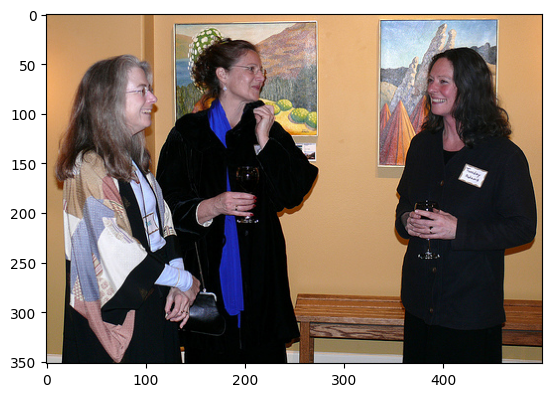

In [30]:
generate_caption("3271252073_0a1b9525fc.jpg")

---------------------Actual---------------------
startseq man is standing in front of brick storefront wearing black jacket endseq
startseq man standing on city street endseq
startseq the man is in front of building endseq
startseq young man in warm coat outside storefront endseq
startseq young man with cap and buttoned coat stands before building endseq
--------------------Predicted--------------------
startseq man in black jacket and black jacket in front of brick wall endseq


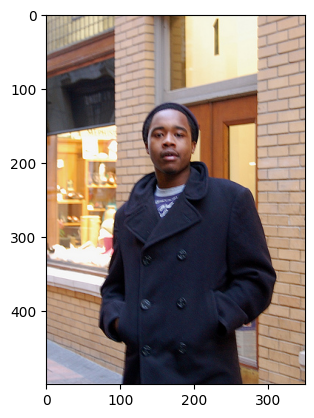

In [31]:
generate_caption("3293751640_d81a6f3a0c.jpg")

---------------------Actual---------------------
startseq person in green feathered costume is bending down in front of woman with painted breasts endseq
startseq woman in green costume is standing in front of topless woman with painted breasts endseq
startseq people in costumes are walking around in the street endseq
startseq two people dressed in green and red costumes are outside on the sidewalk endseq
startseq two people in lavish costumes standing on the street endseq
--------------------Predicted--------------------
startseq two women dressed in costumes are walking in the street endseq


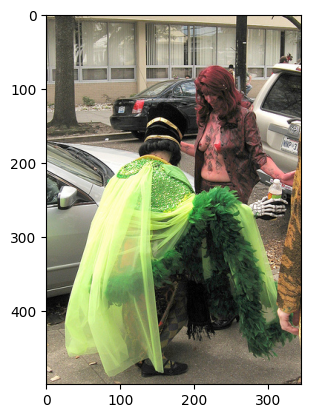

In [32]:
generate_caption("3342272425_804316cb3d.jpg")

## Test with Real Image

In [33]:
xception_model = Xception()
# restructure the model
xception_model = Model(inputs=xception_model.inputs, outputs=xception_model.layers[-2].output)

In [34]:
image_path = '/kaggle/input/test-img/pexels-photo-3605139.jpeg'
# load image
image = load_img(image_path, target_size=(299, 299))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for Xception
image = preprocess_input(image)
# extract features
feature = xception_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq man in red jacket and white coat is skiing down the snow endseq'